In [1]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.quantization
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #Activamos cuda en el caso de que esté disponible

In [2]:
# parameters
RANDOM_SEED = 42 #Semilla para generar números aleatorios
LEARNING_RATE = 0.001 #Tasa de aprendizaje
BATCH_SIZE = 32 #Tamaño del batch
N_EPOCHS = 15 #Número de épocas (vueltas)

IMG_SIZE = 32 #Tamaño de la imagen
N_CLASSES = 10 #Número de clases

In [3]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    scaler = torch.cuda.amp.GradScaler()
    
    with torch.no_grad(): #Las siguientes ejecuciones no tienen el gradiente activado
        model.eval() #Modo de evaluación
        for X, y_true in data_loader: #se obtienen los datos

            with torch.cuda.amp.autocast():
                X = X.to(device) #Se lleva el número a gpu
                y_true = y_true.to(device) #Se lleva el número correcto a gpu

                _, y_prob = model(X) #se obtiene el tensor de predicción de X aplicando el modelo

                _, predicted_labels = torch.max(y_prob, 1) #Se obtiene el mayor valor del tensor para obtener la predicción
            
            n += y_true.size(0) #Aumentamos el número de casos ejecutados
            correct_pred += (predicted_labels == y_true).sum() #Aumentamos el número de aciertos en el caso de que la predicción sea correcta
            
    return correct_pred.float() / n #Obtenemos la tasa de acierto



In [4]:
def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn') #Se utiliza el estilo de dibujo y visualizzación 'Seaborn'

    train_losses = np.array(train_losses) #Transformamos los datos de train_losses en array
    valid_losses = np.array(valid_losses) #Transformamos los datos de valid_losses en array

    fig, ax = plt.subplots(figsize = (8, 4.5)) #Crea el gráfico con sus ejes, la figura y un tamaño de 8 y 4,5

    ax.plot(train_losses, color='blue', label='Training loss') #Configuración de dibujo de la pérdida de entrenamiento (azul)
    ax.plot(valid_losses, color='red', label='Validation loss') #Configuración de dibujo de la pérdida de validación (rojo)
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') #Dibuja la leyenda del gráfico (Pérdidas por época, pérdida y época)
    ax.legend() #Configura la leyenda
    fig.show() #Dibuja el grafico
    
    # change the plot style to default
    plt.style.use('default') #Se utiliza el estilo de dibujo y visualizzación por defecto

In [5]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train() #Entrenamos el modelo
    running_loss = 0 #Inicializamos la pérdida a 0
    
    scaler = torch.cuda.amp.GradScaler()
    for X, y_true in train_loader: #Obtenemos X(imágenes), e Y_true(etiquetas correctas) del dataset 

        optimizer.zero_grad() #Se inician los gradientes a 0
        
        with torch.cuda.amp.autocast():
            X = X.to(device) #Se lleva X a GPU
            y_true = y_true.to(device) #Se lleva y_true a GPU

            # Forward pass
            y_hat, _ = model(X) #Aplicamos el modelo en X y obtenemos la predicción
            X= X.float()
            loss = criterion(y_hat, y_true) #Calculamos la pérdida comparando la predicción con el valor correcto
            running_loss += loss.item() * X.size(0) #Aumentamos el valor de la pérdida total sumando la pérdida actual con el tamaño de la imagen actual
        
        # Scales the loss, and calls backward()
        # to create scaled gradients
        scaler.scale(loss).backward()
        # Unscales gradients and calls
        # or skips optimizer.step()
        scaler.step(optimizer)
        # Updates the scale for next iteration
        scaler.update()
        
        # Backward pass
        #loss.backward() #Acumula el gradiente para el parámetro de pérdida
        #optimizer.step() #Actualiza el parámetro en función del gradiente
        
    epoch_loss = running_loss / len(train_loader.dataset) #Calculamos la pérdida por época
    return model, optimizer, epoch_loss #Devolvemos el modelo, el gradiente y la pérdida por época

In [6]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval() #Evaluamos (validamos) el modelo
    running_loss = 0 #Inicializamos la pérdida a 0
    
    scaler = torch.cuda.amp.GradScaler()
    
    for X, y_true in valid_loader: #Obtenemos X(imágenes), e Y_true(etiquetas correctas) del dataset
        
        with torch.cuda.amp.autocast():
            X = X.to(device) #Se lleva X a GPU
            y_true = y_true.to(device) #Se lleva y_true a GPU

            # Forward pass and record loss
            y_hat, _ = model(X) #Aplicamos el modelo en X y obtenemos la predicción
            loss = criterion(y_hat, y_true) #Calculamos la pérdida comparando la predicción con el valor correcto
            running_loss += loss.item() * X.size(0) #Aumentamos el valor de la pérdida total sumando la pérdida actual

    epoch_loss = running_loss / len(valid_loader.dataset) #Calculamos la pérdida por época
        
    return model, epoch_loss #Devolvemos el modelo y la pérdida por época

In [7]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10 #Inicializamos la mejor pérdida a un valor grande
    train_losses = [] #Creamos array de pérdidas de entrenamiento
    valid_losses = [] #Creamos array de pérdidas de validación
 
    # Train model
    for epoch in range(0, epochs): #Modelo de entrenamiento que recorre todas las épocas

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device) #Llamada a la función de entrenamiento
        train_losses.append(train_loss) #Añadimos al array de pérdidas de entrenamiento, la périda del entrenamiento de la época

        # validation
        with torch.no_grad(): #Las siguientes ejecuciones no tienen el gradiente activado
            model, valid_loss = validate(valid_loader, model, criterion, device) #Llamada a la función de validación
            valid_losses.append(valid_loss) #Añadimos al array de pérdidas de validaciones, la périda de validación de la época

        if epoch % print_every == (print_every - 1): #Condición para imprimir datos cada época
            
            train_acc = get_accuracy(model, train_loader, device=device) #Tasa de acierto de entrenamiento
            valid_acc = get_accuracy(model, valid_loader, device=device) #Tasa de acierto de validación
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}') #Mostramos datos de cada época

    plot_losses(train_losses, valid_losses) #Dibujamos las pérdidas
    
    return model, optimizer, (train_losses, valid_losses) #Devolvemos el modelo, optimizador(gradiente) y pérdidas

In [8]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor(),
                                 transforms.ConvertImageDtype(dtype= torch.bfloat16)]) #Variable que tendrá las especificaciones de los tensores de datos
# download and create datasets
train_dataset = datasets.MNIST(root='mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True) #Descargamos y creamos el dataset de entrenamiento

valid_dataset = datasets.MNIST(root='mnist_data', 
                               train=False, 
                               transform=transforms) #Descargamos y creamos el dataset de validación

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)  #Definimos el dataset de entrenamiento

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)  #Descargamos y creamos el dataset de validación

In [9]:
ROW_IMG = 10
N_ROWS = 5

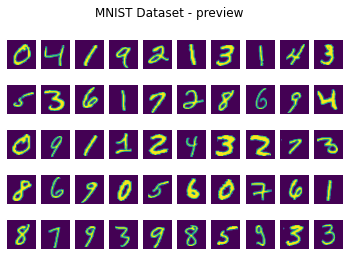

In [10]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview');

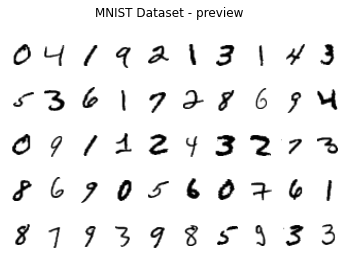

In [11]:
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview');

In [12]:
class LeNet5(nn.Module):

    def __init__(self, n_classes): #Inicializador de Lenet5
        super(LeNet5, self).__init__() #Iniciamos Lenet5
        
        self.feature_extractor = nn.Sequential( #Instrucciones secuenciales que recrean Lenet5         
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1), #Capa1: 1 canal de entrada, 6 de salida, tamaño kernel 5, stride 1
            nn.Tanh(), #Aplica función Tanh
            nn.AvgPool2d(kernel_size=2), #Aplica una agrupación media 2D sobre una señal de entrada compuesta de varios planos de entrada
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1), #Capa2: 6 canales de entrada, 16 de salida, tamaño kernel 5, stride 1
            nn.Tanh(),#Aplica función Tanh
            nn.AvgPool2d(kernel_size=2), #Aplica una agrupación media 2D sobre una señal de entrada compuesta de varios planos de entrada
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1), #Capa3: 1 canales de entrada, 120 de salida, tamaño kernel 5, stride 1
            nn.Tanh()#Aplica función Tanh
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84), #Aplica una transformación linear a los datos de entrada. Datos de entrada: 120, datos de salida: 84
            nn.Tanh(), #Aplica función Tanh
            nn.Linear(in_features=84, out_features=n_classes), #Aplica una transformación linear a los datos de entrada. Datos de entrada: 84, datos de salida: n_classes
        )


    def forward(self, x): #Implementación de Lenet5
        x = self.feature_extractor(x) #Extrae las características de X y las guarda en X
        x = torch.flatten(x, 1) #Aplana un rango de atenuaciones en un tensor. Comienzo de dimensión: X, final de dimensión:1
        logits = self.classifier(x) #Clasificamos los valores de X
        probs = F.softmax(logits, dim=1) #Aplica la función softmax a logits con dimensión 1 para calcular las probabilidades
        return logits, probs #Devuelve logits y probabilidades

In [13]:
#torch.set_default_dtype(torch.float16)
torch.manual_seed(RANDOM_SEED) #Insertamos la semilla manual aleatoria para comenzar

model = LeNet5(N_CLASSES).to(DEVICE) #Guardamos en model Lenet5 con 10 clases y ejecución en GPU
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) #Aplicamos la función de optimización Adam a los parámetros del modelo y con la tasa de aprendizaje
criterion = nn.CrossEntropyLoss() #Cuando no existe un dataset de entrenamoento equilibrado es util. Se encarga de minimizar la pérdida

20:49:39 --- Epoch: 0	Train loss: 0.2311	Valid loss: 0.0891	Train accuracy: 97.46	Valid accuracy: 97.25
20:50:01 --- Epoch: 1	Train loss: 0.0799	Valid loss: 0.0783	Train accuracy: 97.84	Valid accuracy: 97.64
20:50:22 --- Epoch: 2	Train loss: 0.0563	Valid loss: 0.0550	Train accuracy: 98.74	Valid accuracy: 98.27
20:50:43 --- Epoch: 3	Train loss: 0.0443	Valid loss: 0.0492	Train accuracy: 98.93	Valid accuracy: 98.46
20:51:04 --- Epoch: 4	Train loss: 0.0368	Valid loss: 0.0430	Train accuracy: 99.34	Valid accuracy: 98.71
20:51:26 --- Epoch: 5	Train loss: 0.0304	Valid loss: 0.0446	Train accuracy: 99.20	Valid accuracy: 98.58
20:51:47 --- Epoch: 6	Train loss: 0.0265	Valid loss: 0.0492	Train accuracy: 99.36	Valid accuracy: 98.52
20:52:08 --- Epoch: 7	Train loss: 0.0227	Valid loss: 0.0480	Train accuracy: 99.47	Valid accuracy: 98.48
20:52:30 --- Epoch: 8	Train loss: 0.0192	Valid loss: 0.0445	Train accuracy: 99.59	Valid accuracy: 98.73
20:52:51 --- Epoch: 9	Train loss: 0.0177	Valid loss: 0.0459	Trai

<ipython-input-4-b930e5327b66>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show() #Dibuja el grafico


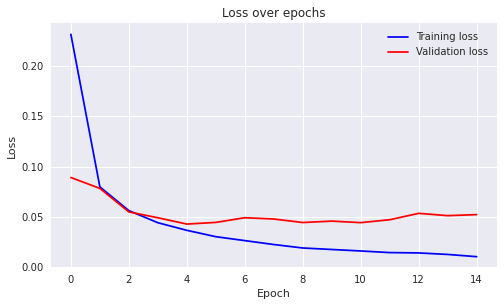

In [14]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

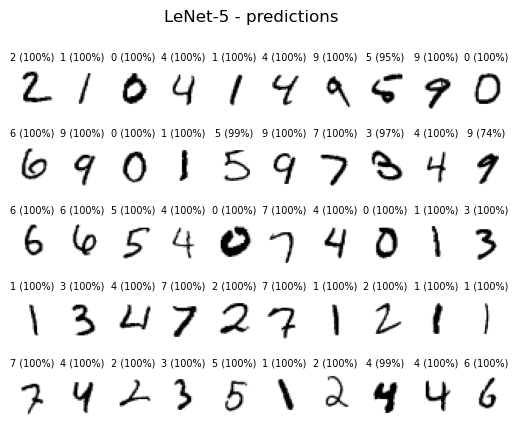

In [15]:
ROW_IMG = 10 #Imágenes por fila
N_ROWS = 5 #Nº de filas

fig = plt.figure() #Dibujo de figura
for index in range(1, ROW_IMG * N_ROWS + 1): #Recorremos la matriz predefinida
    plt.subplot(N_ROWS, ROW_IMG, index) #Reservamos el hueco de la imagen correspondiente
    plt.axis('off') #desactivamos ejes
    plt.imshow(valid_dataset.data[index], cmap='gray_r') #Dibujamos la imagen correspondiente en escala de grises
    
    scaler = torch.cuda.amp.GradScaler()

    with torch.no_grad(): #Las siguientes ejecuciones no tienen el gradiente activado
        model.eval() #evaluamos el modelo
        
        with torch.cuda.amp.autocast():
            _, probs = model(valid_dataset[index][0].cuda().unsqueeze(0)) #Modified, sacamos las probabilidades de acierto
        
    title = f'{torch.argmax(probs)} ({torch.max(probs * 100):.0f}%)' #Imprimimos la predicción  las probabilidades de acierto
    
    plt.title(title, fontsize=7) #Colocamos la predicción como título de la imagen
fig.suptitle('LeNet-5 - predictions'); #Colocamos el título de toda la ejecución

https://discuss.pytorch.org/t/32-float-weight-convert-16-float-model/88754/2


https://pytorch.org/docs/master/amp.html

https://gist.github.com/mcarilli/43445260404c8d7cd79d84439808250e

https://pytorch.org/docs/master/amp.html